In [1]:
!pip install gcm-filters
!pip install xhistogram==0.3.0

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40369")
client

<Client: 'tcp://127.0.0.1:40369' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:35245' processes=0 threads=0, memory=0 B>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
from xhistogram.xarray import histogram as xhist
import gcm_filters
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()

hycom50_grid = cat.HYCOM50(region='1_GS', datatype='grid', grid='grid').to_dask()

In [6]:
hycom01ww = cat.HYCOM50(region='1_GS', datatype='int_wvel', season='fma', decode_times=False).to_dask().chunk({'lat':100,'lon':100})
hycom01w = cat.HYCOM50(region='1_GS', datatype='int', season='fma', decode_times=False).to_dask().chunk({'lat':100,'lon':100})
u3 = hycom01w.u3
v3 = hycom01w.v3
hycom01w = hycom01w.drop('u3')
hycom01w = hycom01w.drop('v3')
Ny = len(hycom50_grid.lat)
Nx = len(hycom50_grid.lon)

## Make metadata C-grid again ##

hycom01w['u3'] = xr.DataArray(u3.data, dims=['time','lay','lat','lonG'],
                              coords={'time':hycom01w.time,'lay':hycom01w.lay,
                                      'lat':hycom01w.lat,'lonG':np.arange(-.5,Nx-.5,1)}
                             )
hycom01w['v3'] = xr.DataArray(v3.data, dims=['time','lay','latG','lon'],
                              coords={'time':hycom01w.time,'lay':hycom01w.lay,
                                      'latG':np.arange(-.5,Ny-.5,1),'lon':hycom01w.lon}
                             )
hycom01w.coords['layl'] = np.arange(-.5,31,1)
hycom01w['w3'] = xr.DataArray(hycom01ww.wvel.data, dims=['time','layl','lat','lon'],
                              coords={'time':hycom01w.time,'layl':hycom01w.layl,
                                      'lat':hycom01w.lat,'lon':hycom01w.lon}
                             )
h3l = xr.DataArray(xr.concat([.5*hycom01w.h3.isel(lay=0), .5*(hycom01w.h3.isel(lay=slice(None,-1)).data
                                                              + hycom01w.h3.isel(lay=slice(1,None)))
                             ], 'lay').transpose('time','lay','lat','lon').data,
                   dims=['time','layl','lat','lon'],
                   coords={'time':hycom01w.time,'layl':hycom01w.layl,
                           'lat':hycom01w.lat,'lon':hycom01w.lon}
                  )

Zl = h3l.cumsum('layl',skipna=True)
Zl = Zl.where(Zl>0.).load()
Z = hycom01w.h3.cumsum('lay',skipna=True)
Z = Z.where(Z>0.).load()

hycom01w['Z'] = Z
hycom01w['Zl'] = Zl

coords={'T':{'center':'time'},
        'X':{'center':'lon', 'left':'lonG'}, 
        'Y':{'center':'lat', 'left':'latG'}, 
        'Z':{'center':'lay', 'left':'layl'}
       }

grid = Grid(hycom01w, coords=coords, periodic=[])

hycom01w['Zu'] = grid.interp(Z, 'X', boundary='fill')
hycom01w['Zv'] = grid.interp(Z, 'Y', boundary='fill')

import gsw
xx, yy = np.meshgrid(hycom50_grid.longitude, hycom50_grid.latitude)
dxF = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                   coords={'lat':hycom01w.lat,'lon':np.arange(.5,Nx-1,1)}
                  ).interp(lon=hycom01w.lon, method="linear",
                           kwargs={"fill_value": "extrapolate"})
dyF = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                   coords={'lat':np.arange(.5,Ny-1,1),'lon':hycom01w.lon}
                  ).interp(lat=hycom01w.lat, method="linear",
                           kwargs={"fill_value": "extrapolate"})
dxC = xr.DataArray(xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                                coords={'lat':hycom01w.lat,'lon':np.arange(.5,Nx-1,1)}
                               ).interp(lon=hycom01w.lonG, method="linear",
                                        kwargs={"fill_value": "extrapolate"}),
                   dims=['lat','lonG'],
                   coords={'lat':hycom01w.lat,'lonG':hycom01w.lonG}
                  )
dyC = xr.DataArray(xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                                coords={'lat':np.arange(.5,Ny-1,1),'lon':hycom01w.lon}
                               ).interp(lat=hycom01w.latG, method="linear",
                                        kwargs={"fill_value": "extrapolate"}),
                   dims=['latG','lon'],
                   coords={'latG':hycom01w.latG,'lon':hycom01w.lon}
                  )
dxG = xr.DataArray(xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                                coords={'lat':hycom01w.lat,'lon':np.arange(.5,Nx-1,1)}
                               ).interp(lon=hycom01w.lon, method="linear",
                                        kwargs={"fill_value": "extrapolate"}
                                       ).interp(lat=hycom01w.latG, method='linear',
                                                kwargs={"fill_value": "extrapolate"}),
                   dims=['latG','lon'],
                   coords={'latG':hycom01w.latG,'lon':hycom01w.lon}
                  )
dyG = xr.DataArray(xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                                coords={'lat':np.arange(.5,Ny-1,1),'lon':hycom01w.lon}
                               ).interp(lat=hycom01w.lat, method="linear",
                                        kwargs={"fill_value": "extrapolate"}
                                       ).interp(lon=hycom01w.lonG, method='linear',
                                                kwargs={"fill_value": "extrapolate"}),
                   dims=['lat','lonG'],
                   coords={'lat':hycom01w.lat,'lonG':hycom01w.lonG}
                  )

hycom01w['dxF'] = dxF
hycom01w['dyF'] = dyF
hycom01w['dxC'] = dxC
hycom01w['dyC'] = dyC
hycom01w['dxG'] = dxG
hycom01w['dyG'] = dyG
hycom01w

<xarray.Dataset>
Dimensions:    (lat: 615, latG: 615, lay: 32, layl: 32, lon: 503, lonG: 503, time: 90)
Coordinates:
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lay        (lay) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * lat        (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * lonG       (lonG) float64 -0.5 0.5 1.5 2.5 3.5 ... 498.5 499.5 500.5 501.5
  * latG       (latG) float64 -0.5 0.5 1.5 2.5 3.5 ... 610.5 611.5 612.5 613.5
  * layl       (layl) float64 -0.5 0.5 1.5 2.5 3.5 ... 26.5 27.5 28.5 29.5 30.5
Data variables: (12/19)
    h3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 100, 100), meta=np.ndarray>
    latitude   (lat) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    layer      (lay) float32 dask.array<chunksize=(32,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    s3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 100, 100), meta=np.ndarray>
    t3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 100, 100), meta=np.ndarray>
    ...         ...
    dxF        (lat, lon) float64 1.925e+03 1.925e+03 ... 1.702e+03 1.702e+03
    dyF        (lat, lon) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03
    dxC        (lat, lonG) float64 1.925e+03 1.925e+03 ... 1.702e+03 1.702e+03
    dyC        (latG, lon) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03
    dxG        (latG, lon) float64 1.925e+03 1.925e+03 ... 1.702e+03 1.702e+03
    dyG        (lat, lonG) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03

In [7]:
zs = np.concatenate((np.linspace(3.1,35.97241992,10, endpoint=False), (1+np.tanh(np.linspace(-2,0,40)))*1e3))
zp1s = np.concatenate((np.array([1.55]),.5*(zs[1:] + zs[:-1])))
from scipy.interpolate import interp1d
f = interp1d(np.arange(len(np.diff(zp1s))), np.abs(np.diff(zp1s)), fill_value='extrapolate')
dzp1s = f(np.arange(len(np.diff(zp1s))+1))

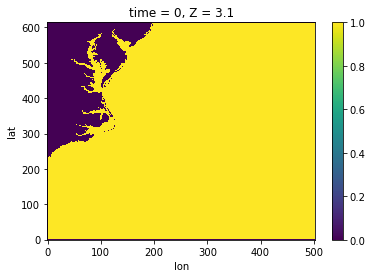

In [8]:
sw = grid.transform(hycom01w.s3.chunk({'lay':-1}), 
                    'Z', zs, 
                    target_data=hycom01w.Z.chunk({'lay':-1})
                   ).transpose('time','Z','lat','lon')
mask = ~np.ma.masked_invalid(sw).mask

wet_mask = xr.DataArray(np.zeros((len(hycom01w.time),len(zs),len(hycom01w.lat),len(hycom01w.lon))),
                        dims=['time','Z','lat','lon'],
                        coords={'time':hycom01w.time,'Z':zs,
                                'lat':hycom01w.lat,'lon':hycom01w.lon}
           )
wet_mask[...,1:-1,1:-1] = mask[...,1:-1,1:-1].astype(np.float64)
wet_mask = wet_mask.chunk({'time':10,'Z':10,'lat':100,'lon':100})
wet_mask.isel(time=0,Z=0).plot()

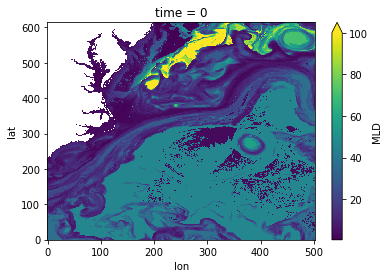

In [9]:
grav = 9.81
w_path = f'{SCRATCH}/region01/HYCOM50/'+f'sigma0_fma.zarr'
sig0w = xr.open_zarr(gcs.get_mapper(w_path)).sig0.chunk({'lat':100,'lon':100})

b_win = -xr.DataArray(sig0w.data, dims=hycom01w.t3.dims, coords=hycom01w.t3.coords) * grav / 1e3


MLDw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/HYCOM50/MLD_fma.zarr")
                   ).MLD.chunk({'time':10,'lat':100,'lon':100})
MLDw.isel(time=0).plot(vmax=100)

In [10]:
area = (hycom01w.dxF * hycom01w.dyF)

In [11]:
dxw = xr.DataArray(hycom01w.dxC.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(hycom01w.dyG.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(hycom01w.dxG.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(hycom01w.dyC.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at southern cell edge
dxw

<xarray.DataArray (lat: 615, lon: 503)>
array([[1925.11172042, 1925.11172042, 1925.11172042, ..., 1928.05082228,
        1925.11172042, 1925.11172042],
       [1924.77578622, 1924.77578622, 1924.77578622, ..., 1927.71437519,
        1924.77578622, 1924.77578622],
       [1924.43975016, 1924.43975016, 1924.43975016, ..., 1927.3778261 ,
        1924.43975016, 1924.43975016],
       ...,
       [1702.88900321, 1702.88900321, 1702.88900321, ..., 1705.48883374,
        1702.88900321, 1702.88900321],
       [1702.50700215, 1702.50700215, 1702.50700215, ..., 1705.10624947,
        1702.50700215, 1702.50700215],
       [1702.12487936, 1702.12487936, 1702.12487936, ..., 1704.72354329,
        1702.12487936, 1702.12487936]])
Coordinates:
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614

In [12]:
dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min()
            )
dx_min = dx_min.values
dx_min

array(1702.12487936)

In [13]:
kappa_w = xr.ones_like(wet_mask.isel(time=0))
kappa_s = xr.ones_like(wet_mask.isel(time=0))

In [14]:
filter_scale = 30000   # 30 km
filter_30km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'lat':-1,'lon':-1}), 
        'dxw': dxw.chunk({'lat':-1,'lon':-1}), 'dyw': dyw.chunk({'lat':-1,'lon':-1}), 
        'dxs': dxs.chunk({'lat':-1,'lon':-1}), 'dys': dys.chunk({'lat':-1,'lon':-1}), 
        'area': area.chunk({'lat':-1,'lon':-1}), 
        'kappa_w': kappa_w.chunk({'lat':-1,'lon':-1}), 'kappa_s': kappa_s.chunk({'lat':-1,'lon':-1})
    }
)
filter_30km

Filter(filter_scale=30000, dx_min=array(1702.12487936), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=20, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [13]:
At = area

ncoars = 5

In [14]:
bw = grid.transform(b_win.chunk({'lay':-1}), 
                    'Z', zs, 
                    target_data=hycom01w.Z.chunk({'lay':-1})
                   ).transpose('time','Z','lat','lon').compute().chunk({'time':10,'Z':10,'lat':100,'lon':100})

bw

,Array,Chunk
Bytes,10.37 GiB,7.63 MiB
Shape,"(90, 50, 615, 503)","(10, 10, 100, 100)"
Count,1890 Tasks,1890 Chunks
Type,float64,numpy.ndarray


In [20]:
xrdzs = xr.DataArray(dzp1s, dims=['Z'])
xrdzs

<xarray.DataArray (Z: 50)>
array([ 3.193621  ,  3.28724199,  3.28724199,  3.28724199,  3.28724199,
        3.28724199,  3.28724199,  3.28724199,  3.28724199,  3.28724199,
        3.54764146,  4.00508682,  4.41857019,  4.87252431,  5.37042207,
        5.91592588,  6.51287229,  7.1652487 ,  7.87716075,  8.65278859,
        9.49632995, 10.41192823, 11.40358345, 12.47504419, 13.62967876,
       14.8703244 , 16.19911391, 17.61728007, 19.12493942, 20.72085899,
       22.40221107, 24.16432403, 26.00043946, 27.90148896, 29.85590644,
       31.84949421, 33.86536253, 35.8839629 , 37.88323384, 39.83887484,
       41.72475863, 43.51348399, 45.17706184, 46.68771554, 48.01876536,
       49.1455555 , 50.04637364, 50.70330799, 51.10298599, 51.50266399])
Dimensions without coordinates: Z

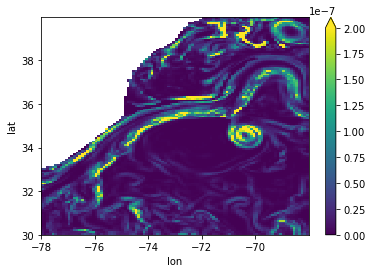

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
gcs://meom-ige-scratch/roxyboy/region01/HYCOM50/MLI-30km_z0-MLD_fma.zarr


In [21]:
for i in range(len(hycom01w.time)):
    
    bm = filter_30km.apply(bw.chunk({'lat':-1,'lon':-1}), dims=['lat','lon']
                          ).isel(time=i).chunk({'Z':10,'lat':100,'lon':100})
    
    bmx = grid.interp(bm,'X',boundary='extend'
          )
    bmy = grid.interp(bm,'Y',boundary='extend'
          )
    dbmx = grid.diff(bmx,'X',boundary='extend') * dxF**-1
    dbmy = grid.diff(bmy,'Y',boundary='extend') * dyF**-1
    
    M2 = np.sqrt(dbmx**2 + dbmy**2).isel(lat=slice(1,-1),lon=slice(1,-1))
    
    M2_coar = ((M2.where(M2.Z<=MLDw.isel(time=i,lat=slice(1,-1),lon=slice(1,-1)))
                * At.isel(lat=slice(1,-1),lon=slice(1,-1))).coarsen({'lat':ncoars,'lon':ncoars},
                                                               boundary='trim').sum(skipna=True)
               * At.isel(lat=slice(1,-1),lon=slice(1,-1)).coarsen({'lat':ncoars,'lon':ncoars},
                                                             boundary='trim').sum(skipna=True)**-1
              )
    
    M2_coarH = (M2_coar 
                * xr.DataArray(xrdzs.where(xrdzs.Z<=MLDw.isel(time=i,lat=slice(1,-1),lon=slice(1,-1))
                                          ).coarsen({'lat':ncoars,'lon':ncoars},
                                                    boundary='trim'
                                                   ).mean(skipna=True).transpose('Z','lat','lon').data,
                               dims=M2_coar.dims, coords=M2_coar.coords)
               ).sum('Z', skipna=True)
    
    mask_coar = wet_mask.isel(time=i,lat=slice(1,-1),lon=slice(1,-1)
                             ).sel(Z=1e2, method='nearest').reset_coords(drop=True).coarsen({'lat':ncoars,'lon':ncoars},
                                                                    boundary='trim').mean(skipna=True)
    
    if i == 0:
        import gsw
        f = xr.DataArray(gsw.f(hycom01w.latitude.isel(lat=slice(1,-1)).coarsen({'lat':ncoars},
                                                                               boundary='trim').mean(skipna=True)
                              ).data, 
                         dims='lat', coords={'lat':M2_coar.lat})
        lat_coar = hycom01w.latitude.isel(lat=slice(1,-1)).coarsen({'lat':ncoars},
                                                                   boundary='trim'
                                                                  ).mean(skipna=True).reset_coords(drop=True)
        lon_coar = hycom01w.longitude.isel(lon=slice(1,-1)).coarsen({'lon':ncoars},
                                                                    boundary='trim'
                                                                   ).mean(skipna=True).reset_coords(drop=True)
    
        MLI = xr.DataArray((M2_coarH**2 
                           / f).where(mask_coar!=0.),
                           dims=['lat','lon'], coords={'lat':lat_coar,'lon':lon_coar}
                          )
        
        MLI.plot(vmax=2e-7)
        plt.show()
    else:
        MLI = xr.concat([MLI, xr.DataArray((M2_coarH**2 
                                           / f).where(mask_coar!=0.),
                                           dims=['lat','lon'], coords={'lat':lat_coar,'lon':lon_coar}
                                          )
                        ], 'time')
    print(i)
        
tmp_path = f'{SCRATCH}/region01/HYCOM50/'+f'MLI-30km_z0-MLD_fma.zarr' 
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLI.to_dataset(name='MLI').to_zarr(store_tmp, mode='w')

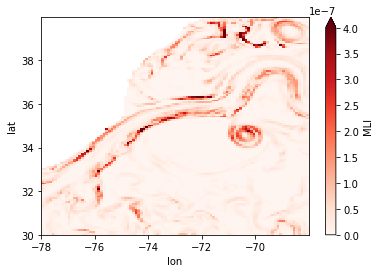

In [15]:
tmp_path = f'{SCRATCH}/region01/HYCOM50/'+f'MLI-30km_z0-MLD_fma.zarr' 
MLI = xr.open_zarr(gcs.get_mapper(tmp_path)).MLI

MLI.isel(time=0).plot(cmap='Reds', vmin=0, vmax=4e-7)

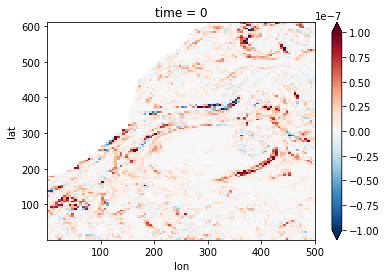

In [16]:
wpbp = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/HYCOM50/wb-30km_z0-MLD_fma.zarr")
                   ).wpbp
mask_coar = wet_mask.isel(lat=slice(1,-1),lon=slice(1,-1)
                         ).sel(Z=1e2, method='nearest').reset_coords(drop=True).coarsen({'lat':ncoars,'lon':ncoars},
                                                                    boundary='trim').mean(skipna=True)
wpbp_coar = ((wpbp * At.isel(lat=slice(1,-1),lon=slice(1,-1))).coarsen({'lat':ncoars,'lon':ncoars},
                                                                  boundary='trim').sum(skipna=True)
             * At.isel(lat=slice(1,-1),lon=slice(1,-1)).coarsen({'lat':ncoars,'lon':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
            ).where(mask_coar!=0.)
wpbp_coar.isel(time=0).plot(cmap='RdBu_r', vmin=-1e-7, vmax=1e-7)

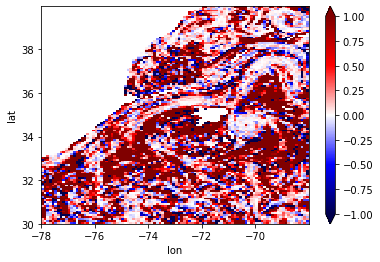

In [20]:
(wpbp_coar.data / MLI).isel(time=0).plot(vmax=1, cmap='seismic')

In [17]:
alpha = (wpbp_coar.data / MLI).median(['lat','lon'],skipna=True).compute()

aMLI = alpha*MLI
aMLI.name = 'MLI'
wpbp_coar = xr.DataArray(wpbp_coar.data, dims=MLI.dims, coords=MLI.coords)
wpbp_coar.name = 'wpbp'

In [18]:
time = np.arange('2012-02', '2012-05', dtype='datetime64[D]')
time

array(['2012-02-01', '2012-02-02', '2012-02-03', '2012-02-04',
       '2012-02-05', '2012-02-06', '2012-02-07', '2012-02-08',
       '2012-02-09', '2012-02-10', '2012-02-11', '2012-02-12',
       '2012-02-13', '2012-02-14', '2012-02-15', '2012-02-16',
       '2012-02-17', '2012-02-18', '2012-02-19', '2012-02-20',
       '2012-02-21', '2012-02-22', '2012-02-23', '2012-02-24',
       '2012-02-25', '2012-02-26', '2012-02-27', '2012-02-28',
       '2012-02-29', '2012-03-01', '2012-03-02', '2012-03-03',
       '2012-03-04', '2012-03-05', '2012-03-06', '2012-03-07',
       '2012-03-08', '2012-03-09', '2012-03-10', '2012-03-11',
       '2012-03-12', '2012-03-13', '2012-03-14', '2012-03-15',
       '2012-03-16', '2012-03-17', '2012-03-18', '2012-03-19',
       '2012-03-20', '2012-03-21', '2012-03-22', '2012-03-23',
       '2012-03-24', '2012-03-25', '2012-03-26', '2012-03-27',
       '2012-03-28', '2012-03-29', '2012-03-30', '2012-03-31',
       '2012-04-01', '2012-04-02', '2012-04-03', '2012-

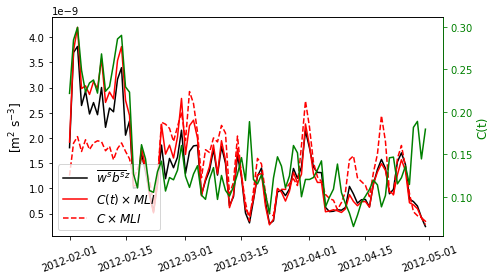

In [19]:
fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(time, wpbp_coar.median(['lat','lon'],skipna=True), c='k', label=r"$\overline{w^sb^s}^z$")
ax.plot(time, aMLI.median(['lat','lon'],skipna=True), c='r', label=r'$C(t) \times MLI$')
ax.plot(time, (alpha.mean('time')*MLI).median(['lat','lon'],skipna=True), c='r', ls='--', label=r'$C \times MLI$')

ax2.plot(time, alpha, c='g')

ax.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=12)
ax.set_xticks(['2012-02-01','2012-02-15','2012-03-01','2012-03-15','2012-04-01','2012-04-15','2012-05-01'])
ax.set_xticklabels(labels=['2012-02-01','2012-02-15','2012-03-01','2012-03-15','2012-04-01','2012-04-15','2012-05-01'],
                   rotation=20)
ax2.set_ylabel(r"C(t)", fontsize=12, c='g')
ax2.spines['right'].set_color('g')
ax2.tick_params(axis='y', colors='g')

ax.legend(loc='lower left', fontsize=12)
plt.savefig('/home/jovyan/Figures/HYCOM50-wb-timeseries_01.pdf')

In [21]:
mask0 = wet_mask.isel(Z=0,lat=slice(1,-1),lon=slice(1,-1)).mean('time').coarsen({'lat':ncoars,'lon':ncoars},
                                                          boundary='trim').mean(skipna=True).reset_coords(drop=True)
mask0 = ~np.ma.masked_values(mask0,0).mask
mask0

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

/tmp/ipykernel_3324/2146511689.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax1.pcolormesh(MLI.lon, MLI.lat, wpbp_coar.isel(time=0),
/tmp/ipykernel_3324/2146511689.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolormesh(MLI.lon, MLI.lat, aMLI.isel(time=0),
/tmp/ipykernel_3324/2146511689.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corn

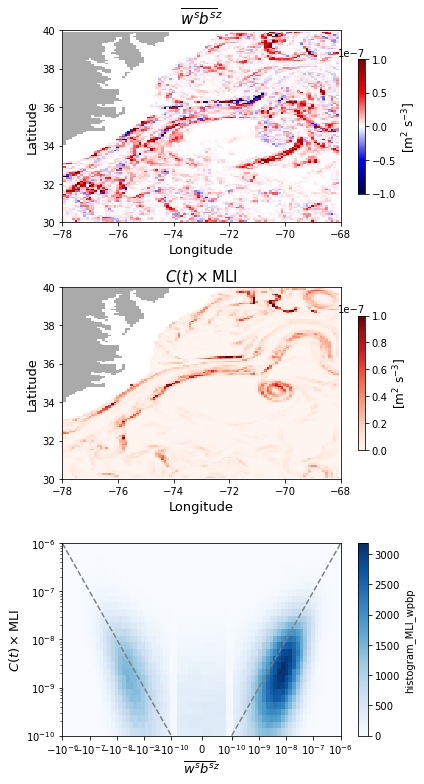

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,11),nrows=3,ncols=1)
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(MLI.lon, MLI.lat, wpbp_coar.isel(time=0),
                     vmin=-1e-7, vmax=1e-7, cmap='seismic', rasterized=True)
im2 = ax2.pcolormesh(MLI.lon, MLI.lat, aMLI.isel(time=0),
                     vmin=0., vmax=1e-7, cmap='Reds', rasterized=True)

ax1.pcolormesh(MLI.lon, MLI.lat, 
               np.ma.masked_array(mask0, mask0),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
ax2.pcolormesh(MLI.lon, MLI.lat, 
               np.ma.masked_array(mask0, mask0),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

xhist((aMLI).chunk({'time':1}), 
      wpbp_coar.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax3, cmap='Blues')

ax1.set_xlim([-78,-68])
ax1.set_ylim([30,40])
ax2.set_xlim([-78,-68])
ax2.set_ylim([30,40])

ax3.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax3.set_xscale('symlog', linthresh=1e-10)
ax3.set_yscale('log')
ax3.set_ylim([1e-10,1e-6])
ax3.set_xlim([-1e-6,1e-6])
ax3.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax3.set_ylabel(r"$C(t)\times$MLI", fontsize=13)
ax1.set_title(r"$\overline{w^sb^s}^z$", fontsize=15)
ax1.set_xlabel(r"Longitude", fontsize=13)
ax1.set_ylabel(r"Latitude", fontsize=13)
ax2.set_title(r"$C(t)\times$MLI", fontsize=15)
ax2.set_xlabel(r"Longitude", fontsize=13)
ax2.set_ylabel(r"Latitude", fontsize=13)

cbar1 = fig.colorbar(im1, ax=ax1, shrink=.7)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)
cbar2.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)

plt.savefig('/home/jovyan/Figures/HYCOM50-wb-hist_01.pdf')